In [1]:
# Import necessary modules
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# <!-- collapse=True -->
from datetime import datetime
from functools import reduce
from os.path import exists
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from cf_utils import ALSRecommender
from cf_utils import DampedUserMovieBaselineModel
from cf_utils import KNNRecommender
from cf_utils import ndcg_from_df
from cf_utils import SGDRecommender

# Use custom matplotlib stylesheet
plt.style.use('./big-darkgrid.mplstyle')

# 2. Load the Data

Let's load and examine the ratings data. If you're following along (i.e. actually running these notebooks) you'll need to make sure to run the first one to download the data before running this one.

In [2]:
# <!-- collapse=True -->
ratings_df = pd.read_csv('raw/ml-100k/u.data', sep='\t', header=None, 
                         names=['userId', 'movieId', 'rating', 'timestamp'])
ratings_df['timestamp'] = ratings_df['timestamp'].apply(datetime.fromtimestamp)
ratings_df = ratings_df.sort_values('timestamp')
print('First 5:')
display(ratings_df.head())
print()
print('Last 5:')
display(ratings_df.tail())

First 5:


,userId,movieId,rating,timestamp
214,259,255,4,1997-09-19 23:05:10
83965,259,286,4,1997-09-19 23:05:27
43027,259,298,4,1997-09-19 23:05:54
21396,259,185,4,1997-09-19 23:06:21
82655,259,173,4,1997-09-19 23:07:23



Last 5:


,userId,movieId,rating,timestamp
46773,729,689,4,1998-04-22 19:10:38
73008,729,313,3,1998-04-22 19:10:38
46574,729,328,3,1998-04-22 19:10:38
64312,729,748,4,1998-04-22 19:10:38
79208,729,272,4,1998-04-22 19:10:38


In [4]:
n_splits = 3
skf = StratifiedKFold(n_splits=n_splits, random_state=0)
splits = [
    (train_inds, test_inds)
    for train_inds, test_inds in skf.split(ratings_df, ratings_df['userId'])
]

In [5]:
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    train_movie_counts = train_df.groupby('userId').movieId.count()
    test_movie_counts = test_df.groupby('userId').movieId.count()
    print("Fold {}:".format(i_fold))
    train_min, train_max = train_movie_counts.min(), train_movie_counts.max()
    test_min, test_max = test_movie_counts.min(), test_movie_counts.max()
    print("  Train: between {} and {} movies per user".format(train_min, train_max))
    print("  Test:  between {} and {} movies per user".format(test_min, test_max))

Fold 0:
  Train: between 13 and 491 movies per user
  Test:  between 7 and 246 movies per user
Fold 1:
  Train: between 13 and 491 movies per user
  Test:  between 7 and 246 movies per user
Fold 2:
  Train: between 14 and 492 movies per user
  Test:  between 6 and 245 movies per user


In [5]:
def cart_prod(df_1, df_2):
    df_1['_dummy_'], df_2['_dummy_'] = 1, 1
    return pd.merge(df_1, df_2, on='_dummy_').drop('_dummy_', axis=1)

In [6]:
def prep_results_df(lists_dict):
    df = pd.DataFrame({'_dummy_': [1]})
    for name, list in lists_dict.items():
        df = cart_prod(df, pd.DataFrame({name: list}))
    return df

In [8]:
lists_dict = {
    'i_fold': np.arange(n_splits),
    'k': [1, 2, 5, 10, 20, 50, 100],
}
k_recs = 3
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
user_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    user_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    user_results_i = user_results_df[user_results_df['i_fold']==i_fold]
    for index, row in user_results_i[['i_fold', 'k']].iterrows():
        t1 = datetime.now()
        model = KNNRecommender(mode='user', k=row['k'], baseline_algo=baseline_algo)
        preds = model.fit(train_df).predict(test_df[['userId', 'movieId']])
        dt = (datetime.now() - t1).total_seconds()
        test_err = mean_absolute_error(test_df['rating'], preds)
        user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
        ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
        print("k={}, i_fold={}: MAE={}, NDCG={}".format(row['k'], row['i_fold'], test_err, ndcg_mean))
        cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
        user_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt

k=1, i_fold=0: MAE=0.8217171086276409, NDCG=0.8332970750330088
k=2, i_fold=0: MAE=0.7877922493993079, NDCG=0.846038490989702
k=5, i_fold=0: MAE=0.7643923597470353, NDCG=0.8601922380222717
k=10, i_fold=0: MAE=0.7569352142929002, NDCG=0.8657164106577543
k=20, i_fold=0: MAE=0.7541217146843059, NDCG=0.8710707229587485
k=50, i_fold=0: MAE=0.7543319868838209, NDCG=0.8715545091152348
k=100, i_fold=0: MAE=0.7562094068153838, NDCG=0.8706646082752447
k=1, i_fold=1: MAE=0.8276570499892861, NDCG=0.836755858659398
k=2, i_fold=1: MAE=0.7907245652092257, NDCG=0.847952101164923
k=5, i_fold=1: MAE=0.7670699043274145, NDCG=0.8587372266261816
k=10, i_fold=1: MAE=0.7589281670498615, NDCG=0.8646511202110496
k=20, i_fold=1: MAE=0.7567479435954885, NDCG=0.8650119668663936
k=50, i_fold=1: MAE=0.757595228518488, NDCG=0.8671280929167878
k=100, i_fold=1: MAE=0.7593726342457829, NDCG=0.8659189944567991
k=1, i_fold=2: MAE=0.8287758172404593, NDCG=0.8339394498035849
k=2, i_fold=2: MAE=0.7925373646821545, NDCG=0.847

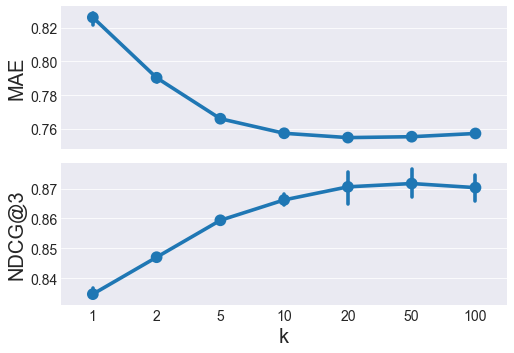

In [9]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=user_results_df, x='k', y='test_err', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
sns.pointplot(data=user_results_df, x='k', y='ndcg_mean', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
fig.subplots_adjust(hspace=0.1)
plt.show()

In [13]:
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
best_user_model = KNNRecommender(mode='user', k=50, baseline_algo=baseline_algo)

In [11]:
lists_dict = {
    'i_fold': np.arange(n_splits),
    'k': [1, 2, 5, 10, 20, 50, 100],
}
k_recs = 3
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
item_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    item_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    item_results_i = item_results_df[item_results_df['i_fold']==i_fold]
    print("i_fold={}: ".format(i_fold), end='')
    for index, row in item_results_i[['i_fold', 'k']].iterrows():
        t1 = datetime.now()
        model = KNNRecommender(mode='item', k=row['k'], baseline_algo=baseline_algo)
        preds = model.fit(train_df).predict(test_df[['userId', 'movieId']])
        dt = (datetime.now() - t1).total_seconds()
        test_err = mean_absolute_error(test_df['rating'], preds)
        user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
        ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
        print("k={}, ".format(row['k']), end='')
        cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
        item_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt
    print()

k=1, i_fold=0: MAE=0.8087636542100971, NDCG=0.8472444897055836
k=2, i_fold=0: MAE=0.7734814291733172, NDCG=0.8552957174195156
k=5, i_fold=0: MAE=0.7472822849213188, NDCG=0.8690699645397623
k=10, i_fold=0: MAE=0.7416082259710042, NDCG=0.8746668996036177
k=20, i_fold=0: MAE=0.7415320869570338, NDCG=0.8734725296681102
k=50, i_fold=0: MAE=0.745014643357032, NDCG=0.8728093835072792
k=100, i_fold=0: MAE=0.7498436604028863, NDCG=0.8670426534524459
k=1, i_fold=1: MAE=0.8045786715369737, NDCG=0.8466461644286389
k=2, i_fold=1: MAE=0.768494154460891, NDCG=0.8618930033657317
k=5, i_fold=1: MAE=0.7497659665604007, NDCG=0.8713582426613038
k=10, i_fold=1: MAE=0.7448621460548477, NDCG=0.8754478384857002
k=20, i_fold=1: MAE=0.7450136445918869, NDCG=0.8717172245307474
k=50, i_fold=1: MAE=0.7491217710602772, NDCG=0.868547041182222
k=100, i_fold=1: MAE=0.7535881378773018, NDCG=0.8646137265179443
k=1, i_fold=2: MAE=0.806347534201409, NDCG=0.8464192014075255
k=2, i_fold=2: MAE=0.7731756759403587, NDCG=0.856

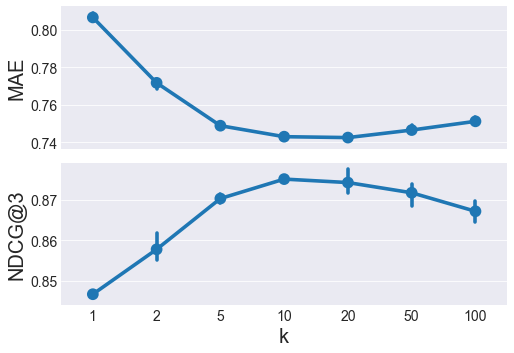

In [12]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=item_results_df, x='k', y='test_err', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
sns.pointplot(data=item_results_df, x='k', y='ndcg_mean', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
fig.subplots_adjust(hspace=0.1)
plt.show()

In [9]:
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
best_item_model = KNNRecommender(mode='item', k=10, baseline_algo=baseline_algo)

In [14]:
max_epochs = 15
lists_dict = {
    'i_fold': np.arange(n_splits),
    'i_epoch': np.arange(max_epochs),
    'k': [5, 10, 50],
}
k_recs = 3
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
als_epoch_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    als_epoch_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    als_epoch_results_i = als_epoch_results_df[als_epoch_results_df['i_fold']==i_fold]
    for k, group in als_epoch_results_i.groupby('k'):
        model = ALSRecommender(k=k, lmbda=0.1, max_epochs=max_epochs, baseline_algo=baseline_algo,
                             verbose=False)
        print('i_fold={}, k={}: i_epoch='.format(i_fold, k), end='')
        for index, row in group[['i_fold', 'i_epoch']].iterrows():
            t1 = datetime.now()
            preds = model.fit(train_df, n_epochs=1).predict(test_df[['userId', 'movieId']])
            dt = (datetime.now() - t1).total_seconds()
            test_err = mean_absolute_error(test_df['rating'], preds)
            user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
            ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
            print('{}, '.format(row['i_epoch']), end='')
            cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
            als_epoch_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt
        print()

i_fold=0, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=0, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=0, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 


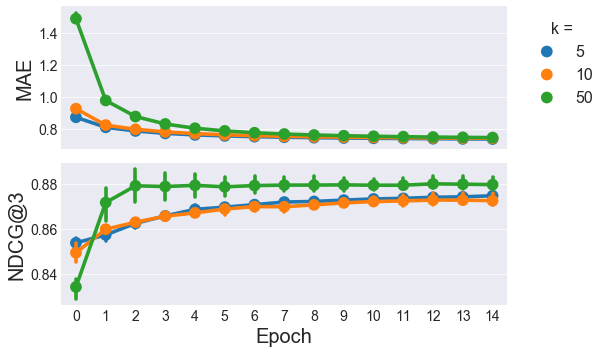

In [21]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=als_epoch_results_df, x='i_epoch', y='test_err', hue='k', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
ax0.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='k =')
sns.pointplot(data=als_epoch_results_df, x='i_epoch', y='ndcg_mean', hue='k', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
ax1.set_xlabel('Epoch')
ax1.legend_.remove()
fig.subplots_adjust(hspace=0.1)
plt.show()

In [17]:
max_epochs = 15
lists_dict = {
    'i_fold': np.arange(n_splits),
    'k': [20, 50, 100, 200],
    'lmbda': [0.05, 0.1, 0.2]
}
k_recs = 3
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
als_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    als_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    als_results_i = als_results_df[als_results_df['i_fold']==i_fold]
    for index, row in als_results_i[['k', 'lmbda']].iterrows():
        model = ALSRecommender(k=row['k'], lmbda=row['lmbda'], max_epochs=max_epochs, baseline_algo=baseline_algo,
                               verbose=False)
        print('i_fold={}, k={}: lmbda={}'.format(i_fold, row['k'], row['lmbda']))
        t1 = datetime.now()
        preds = model.fit(train_df).predict(test_df[['userId', 'movieId']])
        dt = (datetime.now() - t1).total_seconds()
        test_err = mean_absolute_error(test_df['rating'], preds)
        user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
        ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
        cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
        als_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt

i_fold=0, k=20.0: lmbda=0.05
i_fold=0, k=20.0: lmbda=0.1
i_fold=0, k=20.0: lmbda=0.2
i_fold=0, k=50.0: lmbda=0.05
i_fold=0, k=50.0: lmbda=0.1
i_fold=0, k=50.0: lmbda=0.2
i_fold=0, k=100.0: lmbda=0.05
i_fold=0, k=100.0: lmbda=0.1
i_fold=0, k=100.0: lmbda=0.2
i_fold=0, k=200.0: lmbda=0.05
i_fold=0, k=200.0: lmbda=0.1
i_fold=0, k=200.0: lmbda=0.2
i_fold=1, k=20.0: lmbda=0.05
i_fold=1, k=20.0: lmbda=0.1
i_fold=1, k=20.0: lmbda=0.2
i_fold=1, k=50.0: lmbda=0.05
i_fold=1, k=50.0: lmbda=0.1
i_fold=1, k=50.0: lmbda=0.2
i_fold=1, k=100.0: lmbda=0.05
i_fold=1, k=100.0: lmbda=0.1
i_fold=1, k=100.0: lmbda=0.2
i_fold=1, k=200.0: lmbda=0.05
i_fold=1, k=200.0: lmbda=0.1
i_fold=1, k=200.0: lmbda=0.2
i_fold=2, k=20.0: lmbda=0.05
i_fold=2, k=20.0: lmbda=0.1
i_fold=2, k=20.0: lmbda=0.2
i_fold=2, k=50.0: lmbda=0.05
i_fold=2, k=50.0: lmbda=0.1
i_fold=2, k=50.0: lmbda=0.2
i_fold=2, k=100.0: lmbda=0.05
i_fold=2, k=100.0: lmbda=0.1
i_fold=2, k=100.0: lmbda=0.2
i_fold=2, k=200.0: lmbda=0.05
i_fold=2, k=200.0: l

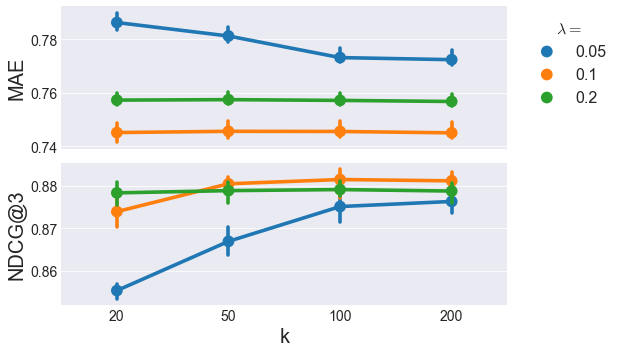

In [20]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=als_results_df, x='k', y='test_err', hue='lmbda', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
ax0.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title=r'$\lambda =$')
sns.pointplot(data=als_results_df, x='k', y='ndcg_mean', hue='lmbda', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
ax1.legend_.remove()
fig.subplots_adjust(hspace=0.1)
plt.show()

In [17]:
baseline_algo = DampedUserMovieBaselineModel(damping_factor=25)
best_als_model = ALSRecommender(k=50, lmbda=0.1, max_epochs=15, baseline_algo=baseline_algo)

In [26]:
max_epochs = 15
lists_dict = {
    'i_fold': np.arange(n_splits),
    'i_epoch': np.arange(max_epochs),
    'k': [5, 10, 50],
}
k_recs = 3
baseline_algo = DampedUserMovieBaselineModel(damping_factor=25)
sgd_epoch_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    sgd_epoch_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    sgd_epoch_results_i = sgd_epoch_results_df[sgd_epoch_results_df['i_fold']==i_fold]
    for k, group in sgd_epoch_results_i.groupby('k'):
        model = SGDRecommender(k=k, learning_rate=0.01, max_epochs=max_epochs, damping_factor=10,
                               verbose=False)
        print('i_fold={}, k={}: i_epoch='.format(i_fold, k), end='')
        for index, row in group[['i_fold', 'i_epoch']].iterrows():
            t1 = datetime.now()
            preds = model.fit(train_df, n_epochs=1).predict(test_df[['userId', 'movieId']])
            dt = (datetime.now() - t1).total_seconds()
            test_err = mean_absolute_error(test_df['rating'], preds)
            user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
            ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
            print('{}, '.format(row['i_epoch']), end='')
            cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
            sgd_epoch_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt
        print()

i_fold=0, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=0, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=0, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 


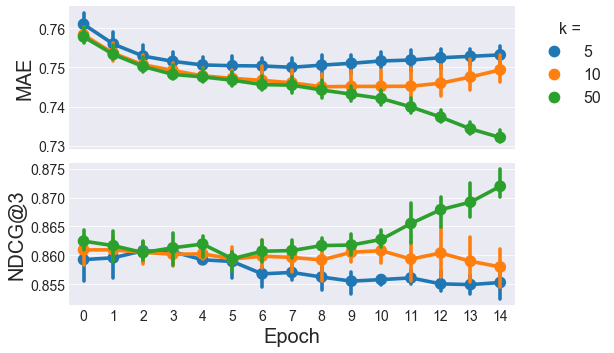

In [27]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=sgd_epoch_results_df, x='i_epoch', y='test_err', hue='k', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
ax0.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='k =')
sns.pointplot(data=sgd_epoch_results_df, x='i_epoch', y='ndcg_mean', hue='k', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
ax1.set_xlabel('Epoch')
ax1.legend_.remove()
fig.subplots_adjust(hspace=0.1)
plt.show()

In [28]:
lists_dict = {
    'i_fold': np.arange(n_splits),
    'learning_rate': [0.001, 0.01],
    'reg': [0.0, 0.001, 0.01],
}
k_recs = 3
k = 50
max_epochs = 30
sgd_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    sgd_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    sgd_results_i = sgd_results_df[sgd_results_df['i_fold']==i_fold]
    for index, row in sgd_results_i[['learning_rate', 'reg']].iterrows():
        learning_rate, reg = row['learning_rate'], row['reg']
        model = SGDRecommender(k=k, learning_rate=learning_rate, max_epochs=max_epochs,
                               damping_factor=10, verbose=False,
                               user_reg=reg, item_reg=reg, user_bias_reg=reg, item_bias_reg=reg)
        print('i_fold={}, learning_rate={}, reg={}'.format(i_fold, learning_rate, reg))
        t1 = datetime.now()
        preds = model.fit(train_df).predict(test_df[['userId', 'movieId']])
        dt = (datetime.now() - t1).total_seconds()
        test_err = mean_absolute_error(test_df['rating'], preds)
        user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
        ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
        cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
        sgd_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt

i_fold=0, learning_rate=0.001, reg=0.0
i_fold=0, learning_rate=0.001, reg=0.001
i_fold=0, learning_rate=0.001, reg=0.01
i_fold=0, learning_rate=0.01, reg=0.0
i_fold=0, learning_rate=0.01, reg=0.001
i_fold=0, learning_rate=0.01, reg=0.01
i_fold=1, learning_rate=0.001, reg=0.0
i_fold=1, learning_rate=0.001, reg=0.001
i_fold=1, learning_rate=0.001, reg=0.01
i_fold=1, learning_rate=0.01, reg=0.0
i_fold=1, learning_rate=0.01, reg=0.001
i_fold=1, learning_rate=0.01, reg=0.01
i_fold=2, learning_rate=0.001, reg=0.0
i_fold=2, learning_rate=0.001, reg=0.001
i_fold=2, learning_rate=0.001, reg=0.01
i_fold=2, learning_rate=0.01, reg=0.0
i_fold=2, learning_rate=0.01, reg=0.001
i_fold=2, learning_rate=0.01, reg=0.01


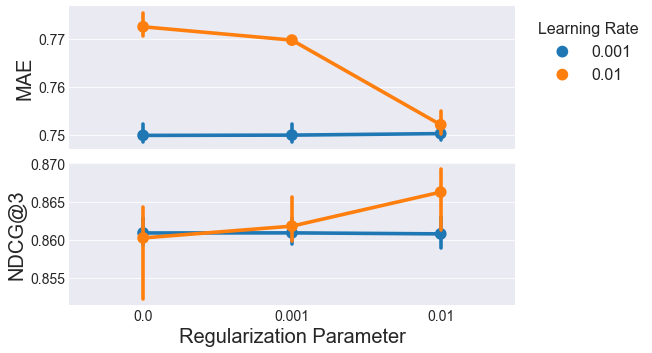

In [30]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=sgd_results_df, x='reg', y='test_err', hue='learning_rate', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
ax0.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='Learning Rate')
sns.pointplot(data=sgd_results_df, x='reg', y='ndcg_mean', hue='learning_rate', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
ax1.set_xlabel('Regularization Parameter')
ax1.legend_.remove()
fig.subplots_adjust(hspace=0.1)
plt.show()

In [18]:
reg = 0.01
best_sgd_model = SGDRecommender(k=50, learning_rate=0.01, max_epochs=30, damping_factor=25,
                                user_reg=reg, item_reg=reg, user_bias_reg=reg, item_bias_reg=reg)

In [22]:
final_models = [best_user_model, best_item_model, best_als_model, best_sgd_model]
final_model_names = ['user', 'item', 'als', 'sgd']
final_results = pd.DataFrame(columns=['model', 'i_fold', 'test_err', 'ndcg_mean', 'ndcg_std', 'dt'])
for model, name in zip(final_models, final_model_names):
    for i_fold, (train_inds, test_inds) in enumerate(splits):
        print("i_fold={}, model={}".format(i_fold, name))
        train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
        if name in ['als', 'sgd']:
            model.verbose = False
        t1 = datetime.now()
        preds = model.fit(train_df).predict(test_df[['userId', 'movieId']])
        dt = (datetime.now() - t1).total_seconds()
        test_err = mean_absolute_error(test_df['rating'], preds)
        user_map, ndcg_array = ndcg_from_df(test_df, preds, k=3)
        ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
        final_results.loc[len(final_results), :] = name, i_fold, test_err, ndcg_mean, ndcg_std, dt

i_fold=0, model=user
i_fold=1, model=user
i_fold=2, model=user
i_fold=0, model=item
i_fold=1, model=item
i_fold=2, model=item
i_fold=0, model=als
i_fold=1, model=als
i_fold=2, model=als
i_fold=0, model=sgd
i_fold=1, model=sgd
i_fold=2, model=sgd


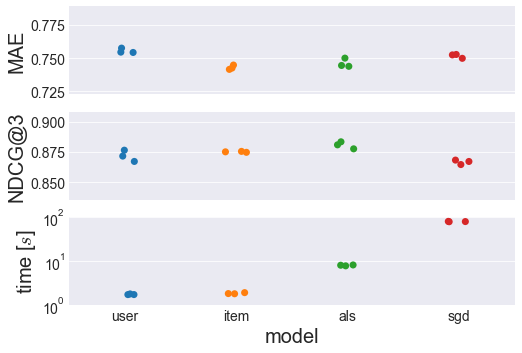

In [37]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True)
sns.stripplot(data=final_results, x='model', y='test_err', ax=ax0, jitter=True)
sns.stripplot(data=final_results, x='model', y='ndcg_mean', ax=ax1, jitter=True)
sns.stripplot(data=final_results, x='model', y='dt', ax=ax2, jitter=True)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
ax1.set_ylabel('NDCG@3')
ax1.set_xlabel('')
ax2.set_ylabel(r'time [$s$]')
ax2.set(yscale='log')
ax2.set_yticks([1, 10, 100])
plt.setp(ax0.collections, sizes=[50])
plt.setp(ax1.collections, sizes=[50])
plt.setp(ax2.collections, sizes=[50])
plt.show()